<a href="https://colab.research.google.com/github/Kaiziferr/Deep_Learning_Workshop/blob/master/RNN/03_workshop_time_series_time_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(data, loock_back = 1):
  dataX, dataY = [], []
  for i in range(len(data) - loock_back-1):
    a = data[i: (i+loock_back), 0]
    dataX.append(a)
    dataY.append(data[i+loock_back, 0])
  return np.array(dataX), np.array(dataY)

# LSTM Time Steps

En lugar de redactar las observaciones pasadas como caracteristicas de entrada separadas, se puede usar como pasos de tiempo de caracteristica de una entrada, que de hecho es un encuadre más preciso del problema. Se puede hacer usando la mima representacion de datos, confiurando columnas para que sean la dimension de pasos de tiempo y cambiar la dimension de caracteristicas de nuevo a 1.

In [3]:
data = pd.read_csv('./data/international-airline-passengers.csv', usecols=[1], engine='python')
data_values = data.values.astype('float32')

In [4]:
#Normalization de datos
scaler = MinMaxScaler(feature_range=(0,1))
data_values = scaler.fit_transform(data_values)

In [5]:
#train and test
train_size = int(len(data_values)*0.67)
test_set = len(data_values) - train_size
train, test = data_values[0:train_size, :], data_values[train_size:, :]
display(len(data_values), len(train), len(test) )

144

96

48

In [6]:
loock_back = 3
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)
for i in range(5):
  print(trainX[i], trainY[i])

[0.01544401 0.02702703 0.05405405] 0.04826255
[0.02702703 0.05405405 0.04826255] 0.032818526
[0.05405405 0.04826255 0.03281853] 0.059845567
[0.04826255 0.03281853 0.05984557] 0.08494207
[0.03281853 0.05984557 0.08494207] 0.08494207


In [7]:
# La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz especifica en forma de [muestras, pasos de tiempo (ventana), caracteristicas]

#Los datos preparados tienen la forma: [muestras, carcteristicas]

#Muestra y caracteristicas
trainX.shape

(92, 3)

In [8]:
# cambia la ventana y la caracteristica
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],1))

In [9]:
trainX[0:5]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.05405405],
        [0.04826255],
        [0.03281853]],

       [[0.04826255],
        [0.03281853],
        [0.05984557]],

       [[0.03281853],
        [0.05984557],
        [0.08494207]]], dtype=float32)

In [10]:
model = Sequential()
model.add(LSTM(4, input_shape = (loock_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 0)

In [11]:
#Predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
#Invert prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [13]:
# Calcular el error
train_score = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Puntuación Entrenamiento: %.2f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Puntuación Test: %.2f RMSE' % (test_score))

Puntuación Entrenamiento: 24.09 RMSE
Puntuación Test: 64.04 RMSE


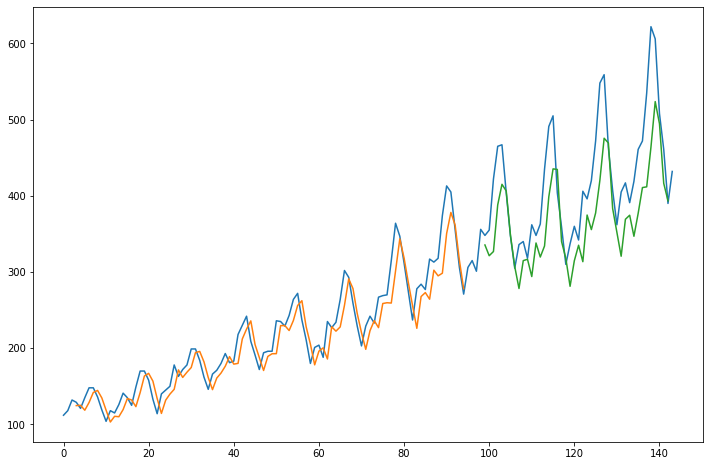

In [14]:
trainPredictPlot = np.empty_like(data_values)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[loock_back: len(trainPredict)+loock_back, :] = trainPredict

testPredictPlot = np.empty_like(data_values)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(loock_back*2)+1:len(data_values)-1,:] = testPredict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data_values))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)